In [1]:
import keras
import model.u_net as unet
import matplotlib.pyplot as plt
from train_board_extractor import train_generator, valid_generator
from board_extractor import extract_board, fix_mask, extract_perspective, find_quadrangle, rotate_quadrangle, scale_approx
import data
import numpy as np
import cv2
import u_net as unet

image_dir = "../data/board_extraction/images/"
mask_dir = "../data/board_extraction/masks/"


Using Theano backend.


## Test board extraction on hi-res labelled images

In [2]:
#load model

model = unet.get_unet_256()
model.load_weights('../../weights/best_weights.hdf5')

In [3]:
print(model)


In [45]:
#get batch of validation data
from train_board_extractor import train_generator, valid_generator, load_image_and_mask_ids
from sklearn.model_selection import train_test_split

ids_train = load_image_and_mask_ids()
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=43)

for ib, mb in valid_generator(ids_valid_split):
    image_batch = ib
    mask_batch = mb
    predicted_mask_batch = model.predict(image_batch)
    break

In [46]:
i = -1

Found 1 contour(s)
Filtered to 1 contour(s)


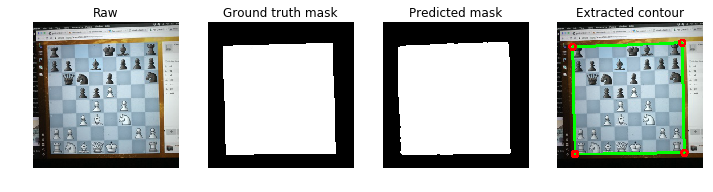

In [50]:

# plot validation data
i += 1

SIZE = (256, 256)
raw = image_batch[i]
image = np.copy(raw)

mask = mask_batch[i].reshape(SIZE)
predicted_mask = fix_mask(predicted_mask_batch[i].reshape(SIZE))

plt.figure(figsize=(12, 12))

plt.subplot(1, 5, 1)
plt.imshow(raw)
plt.title("Raw")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(mask, cmap="gray")
plt.title("Ground truth mask")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted mask")
plt.axis("off")

#approximate

try:
    approx = find_quadrangle(predicted_mask)
    orig_size = (raw.shape[0], raw.shape[1])

    approx = scale_approx(approx, orig_size)
    approx = np.array(approx, dtype=np.int32)
    
    image *= 255
    image = image.astype(np.uint8)
    
    cv2.drawContours(image, [approx], -1, (0, 255, 0), thickness=3)

    for p in approx:
        cv2.circle(image, (p[0][0], p[0][1]), 5, (255, 0, 0), thickness=3)

except Exception as e:
    print(e)
    
    
plt.subplot(1, 5, 4)
plt.imshow(image)
plt.title("Extracted contour")
plt.axis("off")

#extract board
try: 
    board = extract_perspective(raw, approx, 512, 512)
    board = cv2.flip(board, 1)
except: 
    board = np.zeros((256, 256), dtype=np.uint8)

plt.subplot(1, 5, 5)
plt.imshow(board)
plt.title("Board")
plt.axis("off")

plt.show()


In [ ]:
import pydot


In [ ]:
#model.save("../weights/old_best.hdf5")
#print(cv2.__version__)
#default 3.3.1
#tf env  2.4.8
from keras.utils import plot_model
plot_model(model, to_file='../img/model.png')

In [ ]:
plt.hist(im.ravel())
plt.show()